In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import seaborn as sns

import bci.data
import bci.model
import bci.plot

# Classification of Error Related Potentials

## Dataset loading

In [2]:
(X,_),(Xv,_)  = bci.data.load_dataset('data/epochs_300_8000ms.mat')
Sxx_train     = bci.model.compute_spectogram(X)
Sxx_test      = bci.model.compute_spectogram(Xv)

(X_train,y_train),(X_test,_)  = bci.data.load_dataset('data/epochs_300_1500ms.mat')
time          = np.linspace(-500,1000,X_train.shape[-1])

pos, ch2id, ch_label = bci.data.load_calibration('/data/calibration.set')

## Select channels

In [3]:
# Perform t-test between the two classes
p, pi, chs, ids = bci.model.compute_p_values(X_train, y_train, time, n_channels=3)

print("Selected \t{}".format(', '.join(ch_label[i] for i in chs)))

Selected 	Pz, F7, Cz, Cz, FC2, FC1, Pz, P4, CP6


## Cross Validation for hyperparameter search

In [4]:
p, pi, chs, ids = bci.model.compute_p_values(X_train, y_train, time, n_channels=5)

features_train = bci.model.get_features(X_train, chs, ids)
features_test  = bci.model.get_features(X_test,  chs, ids)

accs = None

for i in range(10):
    acc, f1, models = bci.model.run_experiments(X_train, y_train, features_train, n_splits=5)
    
    if accs is None:
        accs = acc
    else:
        accs += acc

pred, best = bci.model.build_ensemble(accs, models, n_models=5)
y_test     = pred(features_test)
p_train    = pred(features_train)

Display cross validation results. Note that in the code, the values are already fixed to the best values found with this procedure

In [5]:
accs / 10

,LinSVC_C 1.000e+00,SVC_C 1.000e-06,SVC_C 1.677e-06,SVC_C 2.812e-06,SVC_C 4.715e-06,SVC_C 7.906e-06,SVC_C 1.326e-05,SVC_C 2.223e-05,SVC_C 3.728e-05,SVC_C 6.251e-05,...,RFO_n 2.000e+00,RFO_n 4.000e+00,RFO_n 6.000e+00,RFO_n 8.000e+00,RFO_n 1.000e+01,RFO_n 1.200e+01,RFO_n 1.400e+01,RFO_n 1.600e+01,RFO_n 1.800e+01,LDA
0,0.831667,0.633333,0.633333,0.633333,0.633333,0.633333,0.633333,0.633333,0.633333,0.633333,...,0.785,0.806667,0.845,0.843333,0.846667,0.838333,0.838333,0.843333,0.841667,0.856667
1,0.84,0.633333,0.633333,0.633333,0.633333,0.633333,0.633333,0.633333,0.633333,0.633333,...,0.8,0.83,0.833333,0.851667,0.858333,0.868333,0.853333,0.863333,0.858333,0.89
2,0.816667,0.633333,0.633333,0.633333,0.633333,0.633333,0.633333,0.633333,0.633333,0.633333,...,0.806667,0.846667,0.856667,0.865,0.85,0.861667,0.861667,0.866667,0.878333,0.86
3,0.868333,0.633333,0.633333,0.633333,0.633333,0.633333,0.633333,0.633333,0.633333,0.633333,...,0.786667,0.84,0.851667,0.863333,0.868333,0.861667,0.868333,0.855,0.86,0.89
4,0.865,0.633333,0.633333,0.633333,0.633333,0.633333,0.633333,0.633333,0.633333,0.633333,...,0.801667,0.835,0.865,0.875,0.868333,0.875,0.871667,0.876667,0.878333,0.898333


Build Ensemble Model and predict

## Create the final model used for predicting the labels

On top of the ensemble, a `resolver module` is implemented. In case of disagreement of the individual classifiers, the resolver will take more advanced feature measures to decide on the class label.

In [126]:
p, pi, chs, ids = bci.model.compute_p_values(X_train, y_train, time, n_channels=3)

features_train = bci.model.get_features(X_train, chs, ids)
features_test  = bci.model.get_features(X_test,  chs, ids)
features_train_ot, features_test_ot = bci.model.optimal_transport(features_train,features_test,y_train,norm=True)

acc, f1, _, predict = bci.model.train_final_models(X_train, y_train,
                                                   features_train, n_splits=10, n_runs=10)

acc_ot, f1_ot, _, predict_ot = bci.model.train_final_models(X_train, y_train,
                                                        features_train_ot, n_splits=10,
                                                        n_runs=5, prefix="OT ")

In [127]:
import pandas as pd

joint_acc = pd.concat([acc,acc_ot], axis=1)
joint_acc

,Ensemble,Final,OT Ensemble,OT Final
0,0.866667,0.903333,1,1
1,0.89,0.9,1,1
2,0.816667,0.76,1,0.98
3,0.856667,0.81,1,0.986667
4,0.88,0.873333,1,0.993333
5,0.896667,0.923333,1,0.986667
6,0.816667,0.893333,1,1
7,0.91,0.916667,1,0.993333
8,0.853333,0.88,1,1
9,0.956667,0.97,1,1


In [130]:
print(joint_acc.to_latex(float_format=lambda x : "{:.1f} %".format(x*100)))

\begin{tabular}{lllll}
\toprule
{} & Ensemble &  Final & OT Ensemble & OT Final \\
\midrule
0 &   86.7 \% & 90.3 \% &     100.0 \% &  100.0 \% \\
1 &   89.0 \% & 90.0 \% &     100.0 \% &  100.0 \% \\
2 &   81.7 \% & 76.0 \% &     100.0 \% &   98.0 \% \\
3 &   85.7 \% & 81.0 \% &     100.0 \% &   98.7 \% \\
4 &   88.0 \% & 87.3 \% &     100.0 \% &   99.3 \% \\
5 &   89.7 \% & 92.3 \% &     100.0 \% &   98.7 \% \\
6 &   81.7 \% & 89.3 \% &     100.0 \% &  100.0 \% \\
7 &   91.0 \% & 91.7 \% &     100.0 \% &   99.3 \% \\
8 &   85.3 \% & 88.0 \% &     100.0 \% &  100.0 \% \\
9 &   95.7 \% & 97.0 \% &     100.0 \% &  100.0 \% \\
\bottomrule
\end{tabular}



62.0% confidently classified as No Error, 20.0% confidently classified as Error, 17.7% unsure cases
54.3% confidently classified as No Error, 23.7% confidently classified as Error, 22.0% unsure cases


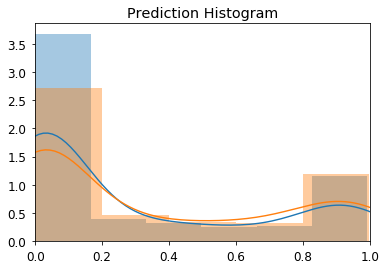

In [123]:
def print_stats(y_test, eps=0.1):
    ax = sns.distplot(y_test)
    ax.set_xlim([0,1])
    ax.set_title("Prediction Histogram")
    print('{:.1f}% confidently classified as No Error, '.format(100*(y_test<eps).mean()) +\
          '{:.1f}% confidently classified as Error, '.format(100*(y_test>1-eps).mean()) +\
          '{:.1f}% unsure cases'.format(100*(abs(.5-y_test) < .5-eps).mean()))

p_test = predict(features_test)
p_test_ot = predict_ot(features_test_ot)

print_stats(p_test,eps=0.2)
print_stats(p_test_ot,eps=0.2)

Use the CorrelationEstimator to remove unsure cases

67.3% confidently classified as No Error, 32.7% confidently classified as Error, 0.0% unsure cases
65.3% confidently classified as No Error, 34.7% confidently classified as Error, 0.0% unsure cases


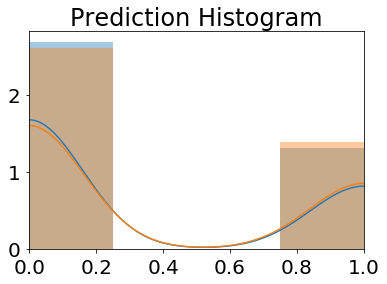

In [104]:
resolver = bci.model.CorrelationEstimator(idx=slice(174,242), channel=[10, 19], eps=0.2)
resolver.fit(X_test, y_test)
y_test = resolver.predict(X_test, y_test)

y_test_ot = p_test > .3

print_stats(y_test,eps=0.3)
print_stats(y_test_ot,eps=0.3)

## Plots for the Reports

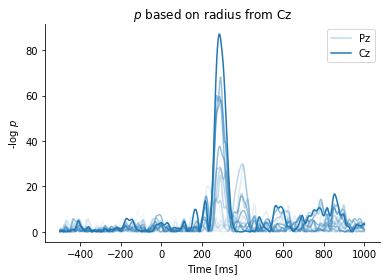

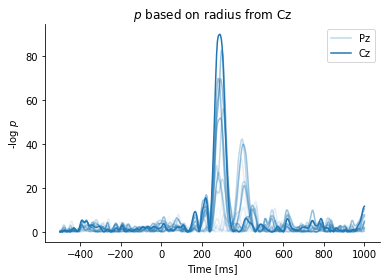

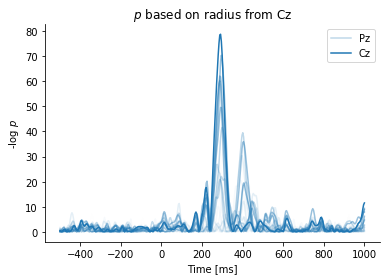

In [75]:
bci.plot.pvalues(time, X_train, y_train, pos, ch2id)
bci.plot.pvalues(time, X_test, y_test, pos, ch2id)
bci.plot.pvalues(time, X_test, y_test_ot, pos, ch2id)

## Visualize the optimal transport adaptation of features

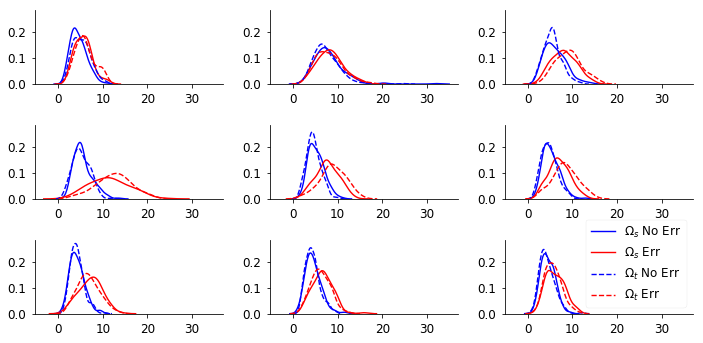

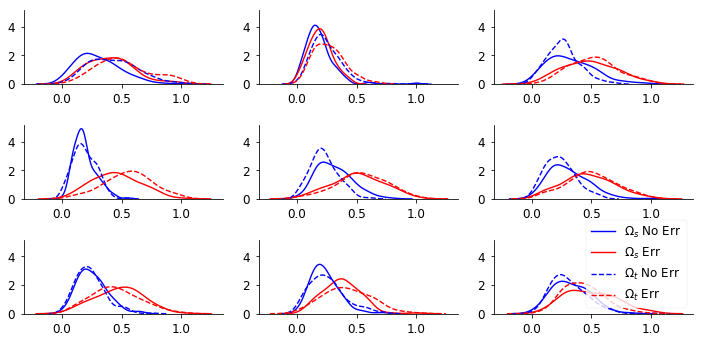

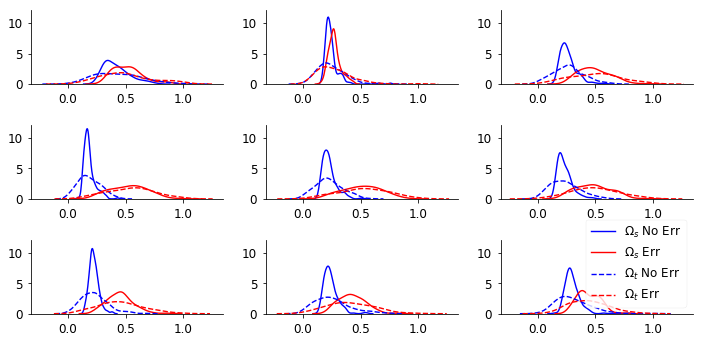

In [106]:
bci.plot.features(features_train, y_train, features_test, y_test)
bci.plot.features(bci.model.normalize(features_train, axis=0), y_train, bci.model.normalize(features_test, axis=0), y_test)
bci.plot.features(features_train_ot, y_train, features_test_ot, y_test_ot)

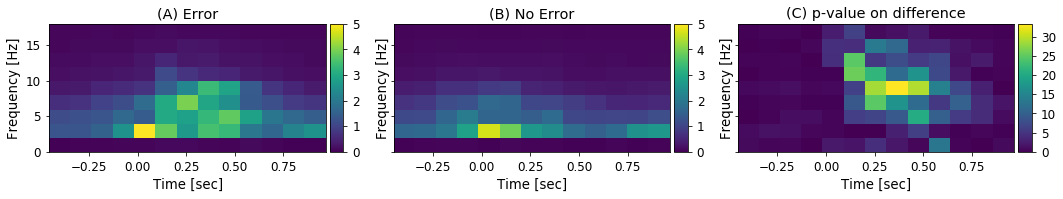

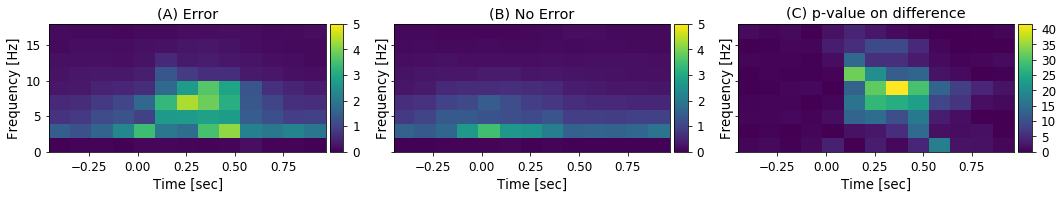

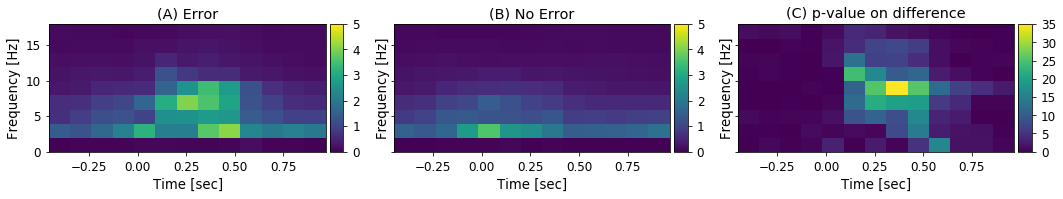

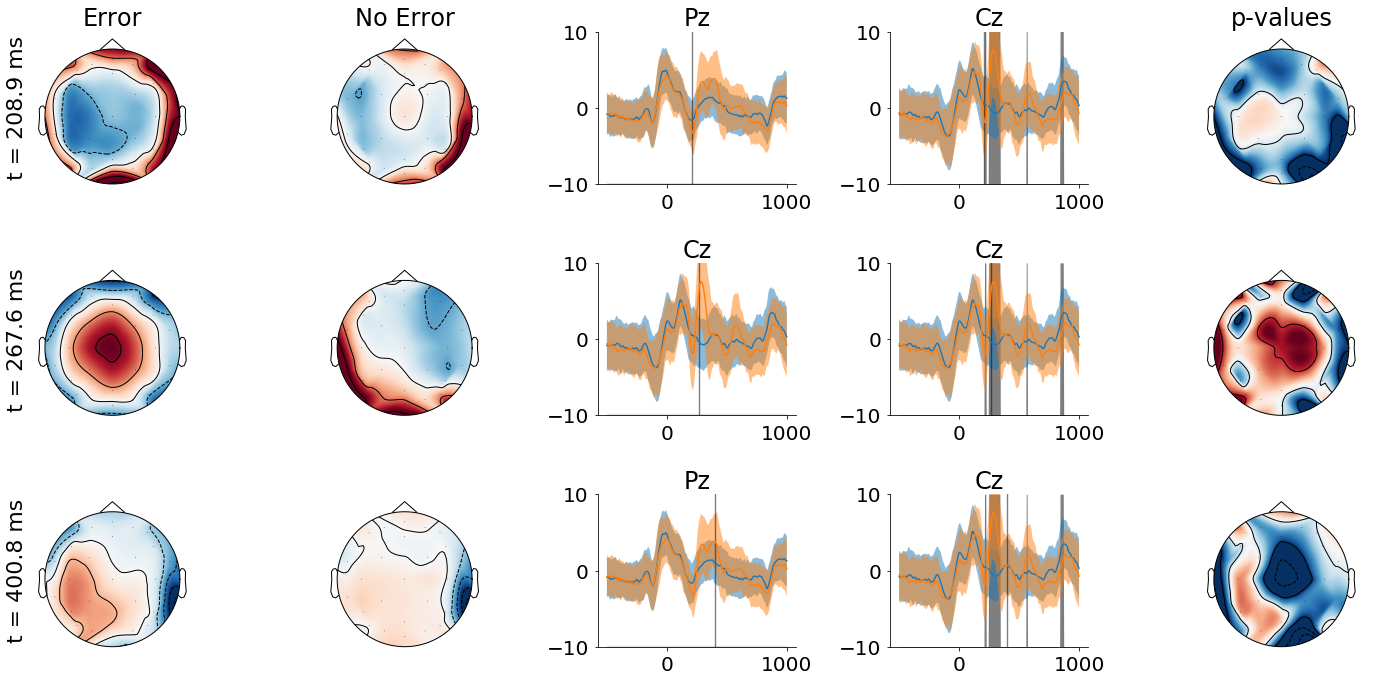

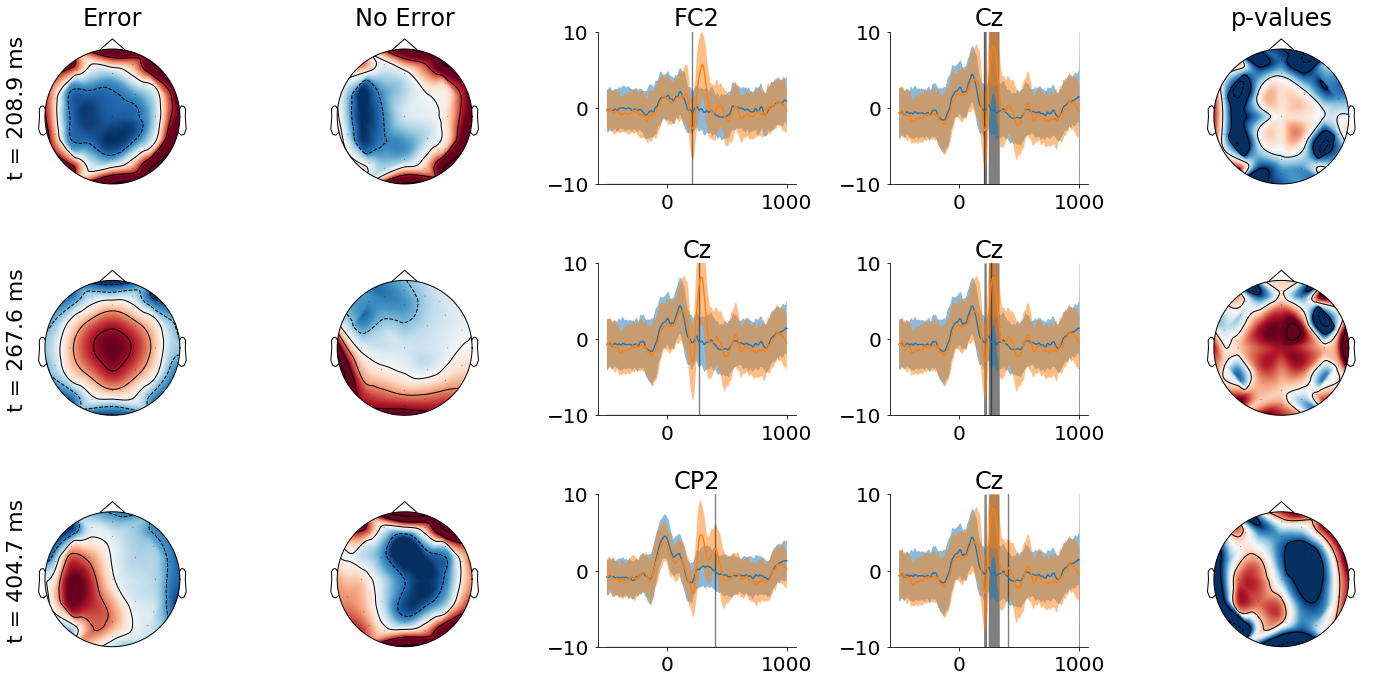

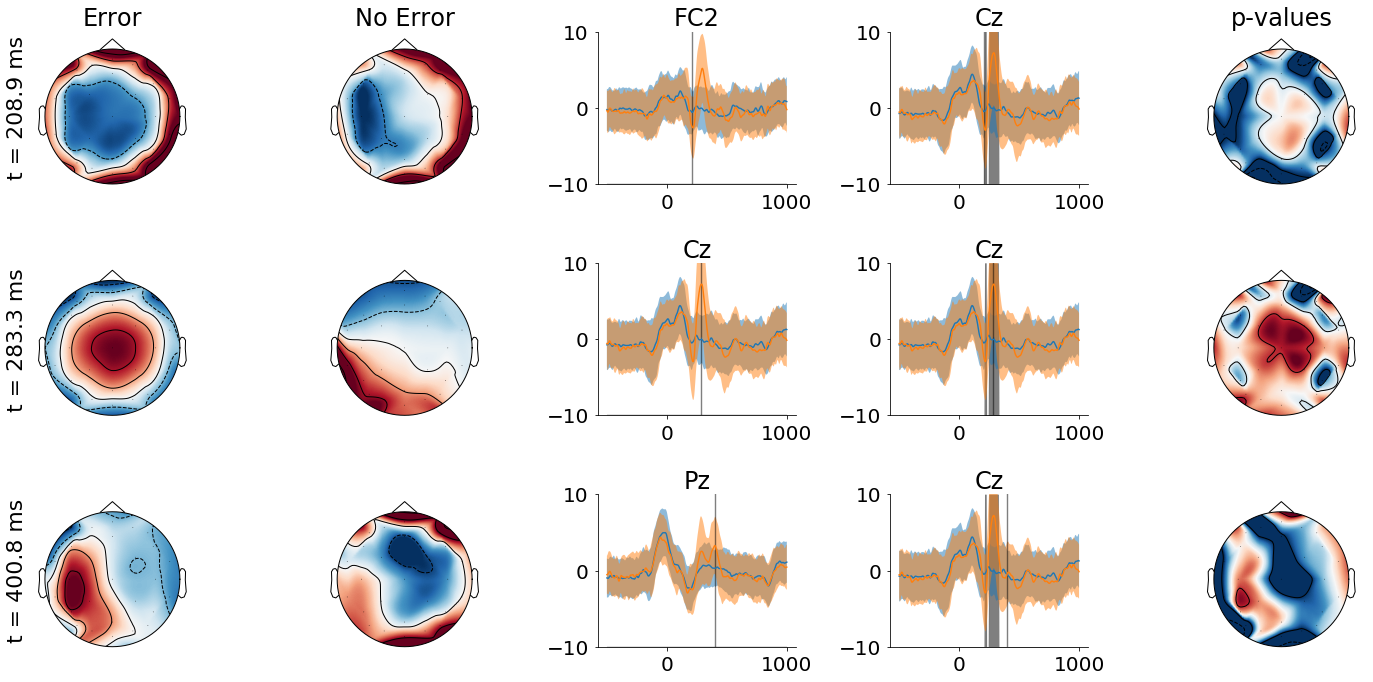

In [131]:
bci.plot.spectrogram(*Sxx_train,y_train, ch2id['Cz'], 'spectrogram-train')
print("="*80)
bci.plot.spectrogram(*Sxx_test, y_test, ch2id['Cz'],  'spectrogram-test')
print("="*80)
bci.plot.spectrogram(*Sxx_test, y_test_ot, ch2id['Cz'],  'spectrogram-ot')
print("="*80)
print("="*80)
bci.plot.overview(X_train, y_train, time, ch2id['Cz'], 'Cz', ch_label, pos, fname='overview-train')
print("="*80)
bci.plot.overview(X_test,  y_test, time, ch2id['Cz'], 'Cz', ch_label, pos, fname='overview-train')
print("="*80)
bci.plot.overview(X_test,  y_test_ot,  time, ch2id['Cz'], 'Cz', ch_label, pos, fname='overview-ot')

The algorithms disagree in 6.667% of the labels


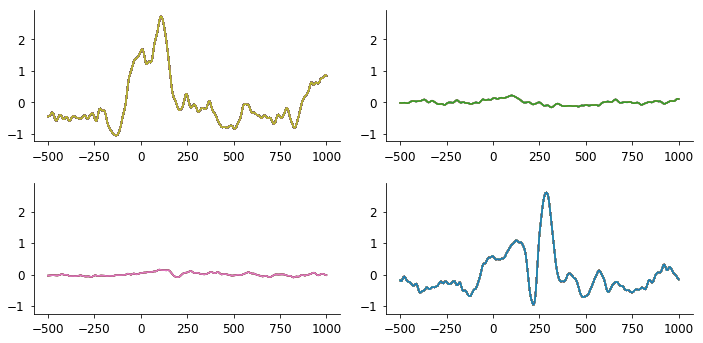

In [134]:
print("The algorithms disagree in {:.3f}% of the labels".format(100*(y_test!=y_test_ot).mean()))
bci.plot.disagreement(time,X_test, y_test, y_test_ot, ch2id['Cz'])

In [139]:
pd.DataFrame(y_test*1)

array([0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1])